# Magnetizer tutorial

This jupyter notebook shows the basic functionality of the [Magnetizer](https://github.com/luizfelippesr/magnetizer/) code.

In [ ]:
import os
os.chdir('..')   # Adjusts the current directory

## Compiling

If all the required libraries are installed and the paths had been adjusted in the Makefile, one should be able to build the code.

If one simple executes `make` or `make help`, there is a brief summary of which components can be built.

In [ ]:
%%bash

make 

We strongly recommend initially using `make test` for compiling the `Magnetizer`. The `make prod` option enables the compiler optimizations and *disables* debugging and backtracing features. Also, when major changes are made to the source, it often a good idea to use the `make cleanall` command to avoid problems.

In [3]:
%%bash 

make test


Building Magnetizer test/debug run

h5pfc build/tsDataObj.o build/bessel_functions.o build/root_finder.o build/constants.o build/grid.o build/floor_field.o build/global_input_parameters.o build/surface_density.o build/pressureEquilibrium.o build/outflow.o build/random.o build/input_parameters.o build/IO_hdf5.o build/profiles.o build/gutsdynamo.o build/ts_arrays.o build/data_transfer.o build/output.o build/dynamo.o build/rotationCurves.o build/deriv.o build/messages.o build/interpolation.o build/integration.o build/seed_field.o build/distributor.o build/Magnetizer.o -I /usr/local/include/fgsl/ -lfgsl -I. -I./source/ -J./build/ -fintrinsic-modules-path ./build -I./build/ -I/usr/include/  -fbacktrace  -ffpe-trap=zero,invalid,overflow -fbounds-check -lgsl -lgslcblas -lm -g -Wall -o Magnetizer.exe


This should have generated the `Magnetizer.exe` executable file in the current working directory.

## Preparing an input file

The Magnetizer code relies on two things in order to run: a **parameters file** and an **input file**. The *parameters file* contains all the setup associated with a particular run. For example, it contains the path to the input and output files, the number of grid points to be used for the profiles, which assumptions should be used for solving the dynamo equations, etc. We will discuss this in another section.

The *input file* contains the properties of the galaxies for which the Magnetizer will compute the ISM and magnetic properties.  This file can be generated from a Galform `galaxies.hdf5` output file using the python script `python/prepare_input.py`, which contains some usage information:

In [4]:
%%bash

./python/prepare_input.py -h

usage: prepare_input.py [-h] [-n NUMBER_OF_GALAXIES]
                        [-nz NUMBER_OF_EXTRA_GALAXIES_PER_Z]
                        [-BoT MAXIMUM_B_OVER_T] [-ms MINIMUM_STELLAR_MASS]
                        [-mg MINIMUM_GAS_MASS] [-Ms MAXIMUM_STELLAR_MASS]
                        [-r MINIMUM_DISK_SIZE] [-z MAX_REDSHIFT] [-naz]
                        SAM_OUTPUT MAGNETIZER_INPUT

Prepares an input file for the Magnetizer.

positional arguments:
  SAM_OUTPUT            HDF5 output file of a Galform run.
  MAGNETIZER_INPUT      Name of the Magnetizer input file to be prepared.

optional arguments:
  -h, --help            show this help message and exit
  -n NUMBER_OF_GALAXIES, --number_of_galaxies NUMBER_OF_GALAXIES
                        Approximate *maximum* number of galaxies to extract
                        from the SAM_OUTPUT file at z=0. The evolution of
                        these galaxies will then be followed.Default: 1e10.
  -nz NUMBER_OF_EXTRA_GALAXIES_PER_Z, --numbe

Here I provide a brief description of what is been done by this script.

The script will start looking at the output at $z=0$, select the specified number of galaxies. For each galaxy, it steps on the merger tree towards higher redshift, always choosing the most massive progenitor branch. Thus, this procedures *converts the original merger tree to a simple time series*, i.e. each galaxy is represented by a time series of properties (instead of a graph).

The sample obtained until now is biased: for $z>0$, only the most massive galaxies of each merger tree are being selected. To avoid this, the script moves to the next available redshift and repeats the procedure (skipping galaxies which had been previously stored). Suppose, for definitness that this next redshift is $z=0.01$, the script will look at a number NUMBER_OF_EXTRA_GALAXIES_PER_Z galaxies at $z=0.01$ that were not picked before. For each of these, it will store the properties of the galaxies and move to the most massive branch. Again, a time series will be generated, but it will end at $z=0.01$ instead of $z=0$, because these galaxies merge (or cease to satisfy the selecton criteria) after this redshift. The absent $z=0$ data is signalled in the input file as -999999 marker (which is ignored both by the Magnetizer programs and the python library).
The procedure then continues analogously for other redshifts.

The seclection criteria (e.g. MINIMUM_DISK_SIZE) are applied on the redshift where the galaxies are first sampled but not on the progenitors of the galaxies (but note that the progenitors do appear in the sample).  To make things concrete, suppose we choose to sample 10 galaxies with disk size greater than 10 kpc. The script will look at $z=0$, try to find 10 galaxies with $ r_\mathrm{disk}>10\,\mathrm{kpc}$, and include those galaxies and all their (most massive) progenitors at $z>0$, even if the progenitors have $ r_\mathrm{disk}<10\,\mathrm{kpc} $ . The reason for this is that, for any sampled galaxy, we want to have access the full history of the galaxy in its time series, so that the Magnetizer can solve the dynamo equations.  To avoid mixing galaxies which are actually sampled with galaxies which are in the sample simply because they are progenitors of sampled galaxies, one can use the "sample_z" property.  A very brute-force and computationally intensive (but often useful) alternative, is to simply use all the galaxies in a given Galform's output, and leave any selection for the analysis step (this is what has actually been done in published work).

An example call to this script (with no filtering) would look like:
```console
./python/prepare_input.py /data/Galform/Lace16/ivol0/galaxies.hdf5 /data/magnetizer_inputs/Lacey16_input.hdf5 
```

*Note: the earlier published results of the Magnetizer project used input files where the galactic disk radii were rescaled so that the median of distribution of radii
at a given mass bin would match the observed relation found by Lange et al 2016 (for more details, please contact Luiz Felippe). This procedure is exemplified for the Lacey 2016 model in the figure below (the blue band corresponds to the interval between the 25th and 75th percentiles in the original output, and red is the corrected version. The second panel show the correction factor which was applied.*

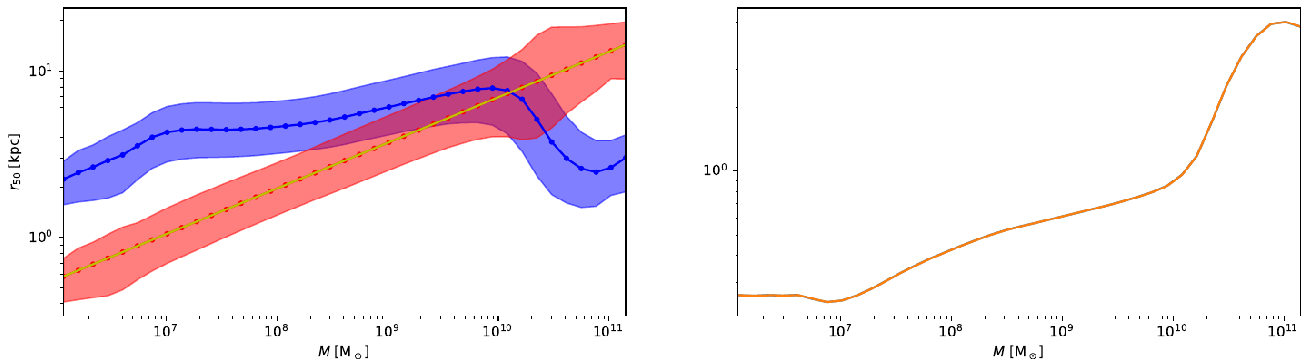


## Parameters file

The input parameters files for a Magnetizer run use Fortran namelists. 
Any parameter skipped in a namelist is set to its default value. 
Thus, an example of a minimal working parameter file would be:

```fortran
&run_parameters  
   model_name = "My run"
   info = 2
/
&io_parameters
  input_file_name = "my_input.hdf5"
  output_file_name = "my_output.hdf5"
  output_quantities_list = 'Bmax'
/
&grid_parameters  
/
&dynamo_parameters
/
&ISM_and_disk_parameters  
/
&outflow_parameters  
/
&observables_parameters 
/
```

The best place to find a description of each parameter and default values is the file [global_input_parameters.f90](../source/global_input_parameters.f90). This file contains the module where all the namelists and global parameters are defined. The `global_input_parameters` module is heavily documented (and should be kept so!) so that the usage of each specific 
parameter should be clear (if something is not clear, please [get in touch](https://github.com/luizfelippesr/magnetizer/issues)).

After a magnetizer run, the parameters are *stored in the output hdf5 file*, to facilitate archival and avoid future confusion.

## Running the Magnetizer

Once the main program is built, one can execute it specifying the parameters file and, *optionally*, a list of galaxy numbers (if one does not supply the list, *all* the galaxies will be in the run).

In [5]:
%%bash 
./Magnetizer.exe example/example_global_parameters.in 42 33

    __  __                        _   _               
   |  \/  | __ _  __ _ _ __   ___| |_(_)_______ _ __  
   | |\/| |/ _` |/ _` | '_ \ / _ \ __| |_  / _ \ '__| 
   | |  | | (_| | (_| | | | |  __/ |_| |/ /  __/ |    
   |_|  |_|\__,_|\__, |_| |_|\___|\__|_/___\___|_|    
                |___/                                 
      
   Runnning on a single processor  
   Using global parameters file: example/example_global_parameters.in  
   Warm up run  
   Galaxy 42 - Finished after  1.221784 s  CPU time
   Warm up done  
   Total number of cycles 1 
   Cycle 1 
 0:  Galaxy 42 - Starting  
 0:  Galaxy 42 - Skipping  
 0:  Galaxy 33 - Starting  
 0:  Galaxy 33 - Finished after  .610656 s  CPU time
 0:  All computing done  
 0:  Finished working on galaxies:          42          33 .
     
   IO finished  
 
   Galaxies in this run:
          42          33
 
   Total wall time in seconds = 2.389590 
   Wall time per galaxy = 1.194795 
   Average CPU per galaxy = 1.194795 
   MPI fin

Invalid MIT-MAGIC-COOKIE-1 key

The verbosity level of the code can be controlled using the `info` parameter in the `run_parameters` namelist. Whereas `info=1` only prints a welcome message and a completion message, `info=5` will log every time step while solving the dynamo equations, every data structure which is generated or saved to the HDF5 output file, etc.

### Running in parallel 

The code supports parallelisation using MPI. However, to allow the code to run in parallel, there is one extra configuration requirement: one needs to disable the HDF5 file locking by setting the environment variable  `HDF5_USE_FILE_LOCKING` to `False`. When running in parallel, only the root process does any writing to disk, but the lock has still has to be disabled to allow that the other processes to read the same files. 

In [6]:
%%bash
export HDF5_USE_FILE_LOCKING=FALSE
mpirun.openmpi -np 3 ./Magnetizer.exe example/example_global_parameters.in 11 12 13 14 21 22 23 24

    __  __                        _   _               
   |  \/  | __ _  __ _ _ __   ___| |_(_)_______ _ __  
   | |\/| |/ _` |/ _` | '_ \ / _ \ __| |_  / _ \ '__| 
   | |  | | (_| | (_| | | | |  __/ |_| |/ /  __/ |    
   |_|  |_|\__,_|\__, |_| |_|\___|\__|_/___\___|_|    
                |___/                                 
      
   Runnning on 3 processors
   Using global parameters file: example/example_global_parameters.in  
   Warm up run  
 0:  Galaxy 11 - Finished after  .891648 s  CPU time
   Warm up done  
   Total number of cycles 1 
   Cycle 1 
 1:  Galaxy 11 - Skipping  
 2:  Galaxy 12 - Finished after  .215221 s  CPU time
 1:  Galaxy 13 - Finished after  .814588 s  CPU time
 2:  Galaxy 14 - Finished after  .685424 s  CPU time
 2:  Galaxy 22 - Timestep became very small! Using maximum number of timesteps instead.  
 1:  Galaxy 21 - Finished after  .874964 s  CPU time
 1:  Galaxy 23 - Timestep became very small! Using maximum number of timesteps instead.  
 2:  Galaxy 22

Invalid MIT-MAGIC-COOKIE-1 key

Our problem is an embarrassingly parallel one, so the parallelisation is done by simply distributing galaxies across the multiple available MPI processes. 

If one is running in parallel, the "root" or "master" process takes care of both sending the tasks to the "worker" processes and saving the results to disk. Some galaxies may take longer to run than others, so the different processes will end up running a different number of galaxies.

The job distribution is preceeded by a "warm-up run", where a single galaxy is ran to completion by the root process. The "warm-up" serves two purposes: it allows one to catch bugs and/or infrastructure problems early-on, and it allows the output file to be generated before the job distribution.

### Checkpointing and stopping a run

The parameter `p_ncheckpoint` (in the `io_parameters` namelist) is used to control the frequency used to save the results. Thus, after `p_ncheckpoint` galaxies have been processed, the root process will flush the HDF5 files to the hard disk and check whether there is any file named `STOP` in the current working directory. If there is no such file, the Magnetizer will proceed and process the next `p_ncheckpoint` galaxies. If, however, a file named `STOP` is found, then the code exits gracefully. 

A `STOP` file is the recommended way of interrupting a Magnetizer run. If instead one simply interrupts the run, there is a chance that the output file could get corrupted (this is specially true if compression is enabled, using `p_IO_compression = .true.` in the `io_parameters` namelist).

## The `MagnetizerRun` python class

The Magnetizer comes with a small python library to facilitate the manipulation of the outputs. Here we briefly summarize its usage.

To import the class, one needs to first include the `python` subdirectory of this repository in the python path.

In [7]:
import sys
sys.path.append('python')
from magnetizer import MagnetizerRun

One initialize the `MagnetizerRun` class one needs to provide paths to the input and output files. 

In [8]:
run = MagnetizerRun(input_path='example/example_input.hdf5',
                    output_path='example/example_output.hdf5')

We can immediately inspect some properties of the run via attributes of the `MagnetizerRun` object

In [9]:
print('Name of the run:', run.name)
print('Number of galaxies in the output:', run.ngals)
print('Number of redshifts:', run.nz)
print('Number of grid points used for profiles:', run.ngrid)
print()

Name of the run: Example run
Number of galaxies in the output: 10
Number of redshifts: 40
Number of grid points used for profiles: 101



The parameters used in the run can be inspected through the `parameters` attribute. This contains another object with dictionaries with all the parameters used in the present magnetizer run (including default values!).

In [10]:
def show_dict(d):
    for k, v in d.items():
        print('\t',k+': ', v)
        
print('Run settings')
show_dict(run.parameters.run)
print('Input/Output settings')
show_dict(run.parameters.io)
print('Grid settings')
show_dict(run.parameters.grid)
print('Dynamo parameters')
show_dict(run.parameters.dynamo)
print('ISM and disc parameters')
show_dict(run.parameters.ISM_and_disk)
print('Observables parameters')
show_dict(run.parameters.observables)

Run settings
	 MODEL_NAME:  "Examplerun"
	 INFO:  2.0
	 NSTEPS_0:  1000.0
	 P_COURANT_V:  0.09000000357627869
	 P_COURANT_ETA:  0.09000000357627869
	 P_VARIABLE_TIMESTEPS:  True
	 P_NSTEPS_MAX:  20000.0
	 P_ONESNAPHOTDEBUGMODE:  False
	 P_NO_MAGNETIC_FIELDS_TEST_RUN:  False
	 P_MAX_FAILS:  6.0
	 P_RANDOM_SEED:  17.0
	 P_MAX_WALLTIME:  -1.0
Input/Output settings
	 OUTPUT_FILE_NAME:  "example/example_output.hdf5"
	 INPUT_FILE_NAME:  "example/example_input.hdf5"
	 P_IO_SEPARATE_OUTPUT:  True
	 P_IO_CHUNKING:  True
	 P_IO_NUMBER_OF_GALAXIES_IN_CHUNKS:  1000.0
	 P_IO_COMPRESSION:  True
	 P_IO_COMPRESSION_LEVEL:  6.0
	 P_MASTER_WORKS_TOO:  False
	 P_MASTER_SKIP:  2.0
	 P_NCHECKPOINT:  5000.0
	 OUTPUT_QUANTITIES_LIST:  "rkpc", "Omega", "Shear", "etat", "alp", "alp_k", "n", "h", "l", "Bmax", "Br", "Bp", "Bzmod", "Bmax_idx", "Uz", "rmax", "Bavg", "Beavg", 17*""
	 OUTPUT_EVERYTHING:  False
Grid settings
	 P_RESCALE_FIELD_FOR_SHRINKING_DISKS:  True
	 P_RESCALE_FIELD_FOR_EXPANDING_DISKS:  False
	 

The method `dump` allows one to save these as a new parameters file
(this is convenient if one only received a set of input/output files and wants to re-run the Magnetizer).

In [11]:
run.parameters.dump('/tmp/parameters.in')

Saving parameters to input file: /tmp/parameters.in


Normally, one will work with multiple input and output files at once, which correspond to different subvolumes of a single Galform run. The paths to multiple input/output files can simply be provided as a list:

```python
run_multiple_vols = MagnetizerRun(input_path=['ivol1_input.hdf5',
                                              'ivol2_input.hdf5',
                                              'ivol1_input.hdf5'],
                                  output_path=['ivol1_output.hdf5',
                                               'ivol2_output.hdf5',
                                               'ivol3_output.hdf5'])
```

The `run_multiple_vols` object will then automatically concatenate the data distributed across multiple files above. It will also automatically remove any galaxies which didn't run to completion or which presented an error while running. 


### Reading the galaxy properties
The main methods of a `MagnetizerRun` object are `MagnetizerRun.get()` and `MagnetizerRun.get_galaxy()`. The former reads and returns a given galaxy property for the whole sample of galaxies at a given redshift, while the latter returns a time series of galaxy property for a single galaxy.


#### The `get` method

Let us illustrate how to obtain the maximum large field strength per galaxy, $B_\mathrm{max}$, at redshift $0$. 

In [12]:
Bmax = run.get('Bmax', 0.0)
print('Type:', type(Bmax))
print('Units:', Bmax.unit)
print('Array shape:', Bmax.shape)

Bmax

Type: <class 'astropy.units.quantity.Quantity'>
Units: uG
Array shape: (10,)


<Quantity [       nan,        nan,        nan,        nan,        nan,
           0.4501087 , 0.42919484, 0.00745451,        nan,        nan] uG>

The NaN entries mark galaxies whose output is absent in this specific redshift. This typically happens if the galaxy experienced a  merger with a more massive galaxy at an earlier redshift. 

We can see that the shape array contains only the galaxies 10 galaxies that we actually ran, earlier in this notebook. All the other galaxies were filtered out.

The `Bmax` object above is actually an [astropy quantity](https://docs.astropy.org/en/stable/units/), which behaves as a regular numpy array but has physical units attached, allowing on-the-fly unit conversions (or errors, if units are incompatible). A quantity object may be expressed as a regular `numpy` array and a `units` object using the following attributes:

In [13]:
Bmax_array, Bmax_units = Bmax.value, Bmax.unit



Not only outputs, as the maximum field strength, can be accessed using the `get()` method but also the inputs. Here we illustrate this showing the distribution of galactic disk half-mass radii (generating a histogram with a kernel density estimate overplotted) at $z=1.07$.

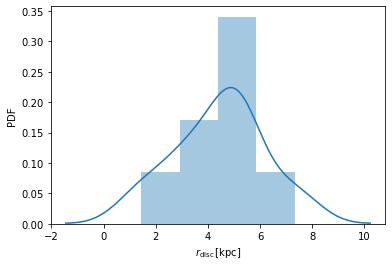

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Loads the disc radii at chosen redshift
rdisk_z1 = run.get('r_disk', z=1.07)

# Masks the NaNs (the absent galaxies)
valid = np.isfinite(rdisk_z1)

# seaborn's `distplot` combines a histogram and a kde
# https://seaborn.pydata.org/
sns.distplot(rdisk_z1[valid])
plt.ylabel('PDF')
plt.xlabel(r'$r_{{\rm disc}}\,[\rm{}]$'.format(rdisk_z1.unit));

As the sample is very small, this plot is obvously rather poor, but it illustrates possibly the most common use of the `get` method: 1) load the quantity, 2) apply some filtering (in this case, removing the NaNs), 3) show the distribution.

Many of the quantities stored in the magnetizer output files are not scalar but *radial profiles*. One example is the azimuthal component, $B_\phi$ , of the large scale magnetic field:

In [15]:
Bphi = run.get('Bp', z=2.07)
Bphi.shape

(10, 101)

If the quantity requested is a profile, each array row corresponds to a different galaxy and each array column to a different radius. To visualize the $B_\phi$ profiles for this small sample, one can do the following

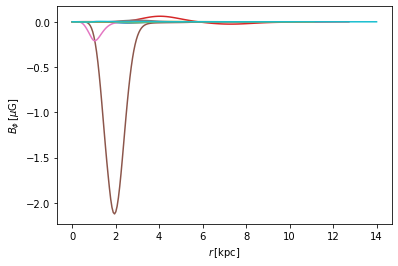

In [16]:
# Gets the radial profiles
r = run.get('r', z=2.07)

# Uses the convenience
for i in range(run.ngals):
    plt.plot(r[i,:], Bphi[i,:])
plt.xlabel(r'$r\,[\rm kpc]$'); plt.ylabel(r'$B_\phi \,[\mu\rm G]$');

We thus find, for instance, that at already $z=2.07$, one of our 10 galaxies displays a strong ($\sim -2\,\mu\rm G$) large scale magnetic field, and that one displays a reversal.



#### The `get_galaxy` method

We can also inspect the individual histories of each galaxy. Below we plot the *evolution of the maximum large scale field strength* for each of the galaxies in this tiny sample.

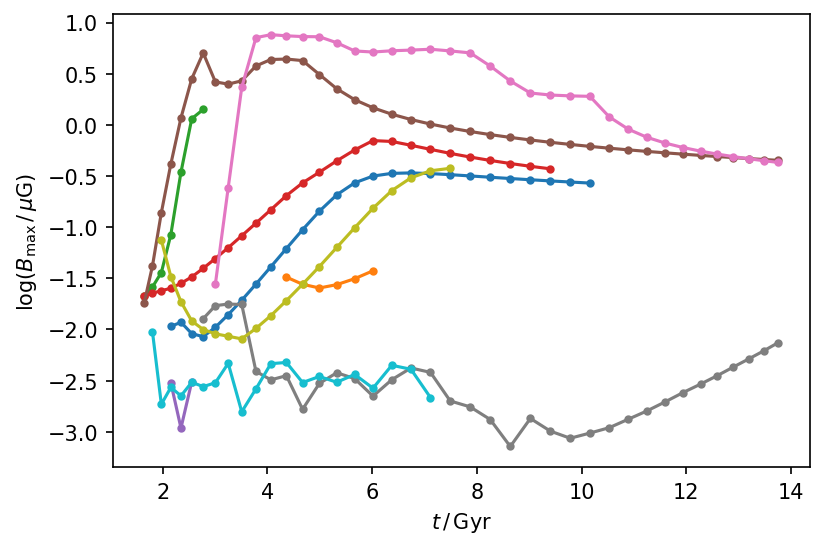

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

plt.figure(dpi=150)
for i in run.gal_id:
    # Extracts the time series for a single galaxy
    Bmax_galaxy = run.get_galaxy('Bmax', gal_id=i)
    
    # Plots the data, as function of time
    plt.plot(run.times, np.log10(Bmax_galaxy/u.microgauss), marker='.')

plt.xlabel(r'$t\,/\,\rm Gyr$'); plt.ylabel(r'$\log(B_{\rm max}\,/\,\mu\rm G)$');

This plot allow us to see the amplification, saturation and decay of the large scale magnetic field of each of the galaxies in the sample.

To construct this plot, we used the `get_galaxy` method, which takes the physical quantity name and the galaxy id as inputs.
We made use of the attribute `MagnetizerRun.times`, which contains the available times since the Big Bang in the simulation.
For convenience, a `MagnetizerRun.redshifts` is also provided. Both are exemplified below, printing the last entries of each.

In [18]:
for z, t in zip(run.redshifts[-5:], run.times[-5:]):
    print(z,'\t',t)

0.08928775787353516 	 12.593470573425293 Gyr
0.06449341773986816 	 12.902968406677246 Gyr
0.04140305519104004 	 13.20085620880127 Gyr
0.01993250846862793 	 13.486539840698242 Gyr
-5.960464477539063e-08 	 13.75954532623291 Gyr


The aforementioned galaxy id is an integer associated with each galaxy in a given input (or output) file. One can access the available galaxy id values using the `MagnetizerRun.gal_id` attribute:

In [19]:
run.gal_id

array([10, 11, 12, 13, 20, 21, 22, 23, 32, 41])

When working with multiple input/output files, the galaxy id does not uniquely identify a galaxy, as one needs to specify to which input/output file pair one refers to.
This information is the `ivol` number, which is also an attribute:

In [20]:
run.ivol

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

As we have only one file, those are all the same and equal to zero (the initial index in python), which is also the default value of ivol in `get_galaxy()`.
The following snippet exemplifies how to plot the galaxy mass evolution of all the galaxies in a multifile context (but which of course also works in this case).

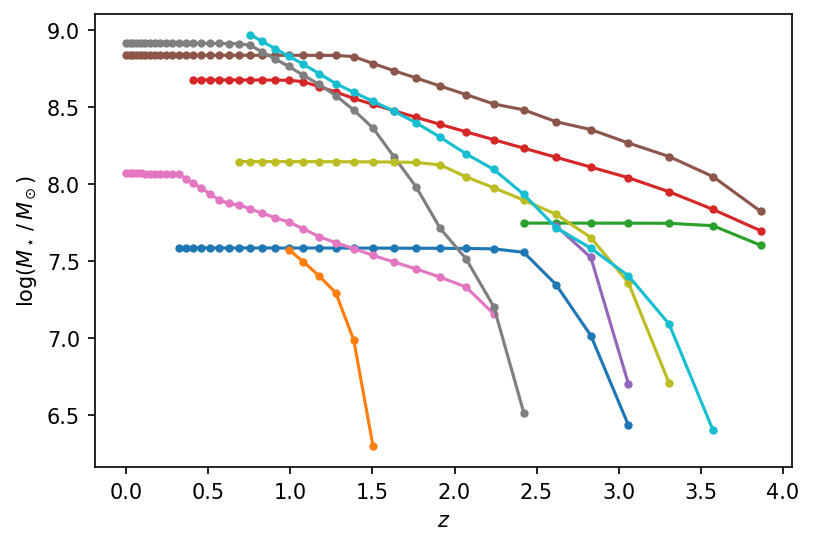

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

plt.figure(dpi=150)

for gal_id, ivol in zip(run.gal_id, run.ivol):
    # Extracts the time series for a single galaxy
    Mstars  = run.get_galaxy('Mstars_disk', gal_id=gal_id, ivol=ivol)
    Mstars += run.get_galaxy('Mstars_bulge', gal_id=gal_id, ivol=ivol)
    
    # Plots the data, as function of time
    plt.plot(run.redshifts, np.log10(Mstars/u.Msun), marker='.')

plt.xlabel('$z$'); plt.ylabel(r'$\log(M_\star\,/\,M_\odot)$');

### Available outputs and computed quantities

Which quantities can one request using the `get`/`get_galaxy` methods?

As it was mentioned, anything that is in the input/output files can be retrieved from the corresponding hdf5 files. 

One can check what is available using the `MagnetizerRun.show_outputs()` method:

In [22]:
run.show_outputs()

Outputs
Quantity    Units        Description
---------   ----------   -----------------------------------
Bavg        microgauss   Surface average magnetic field
Beavg       microgauss   "Energy averaged" magnetic field
Bmax        microgauss   Maximum B
Bmax_idx                 Index of maximum |B|
Bp          microgauss   
Br          microgauss   
Bzmod       microgauss   
Omega       km/s/kpc     Angular velocity
Shear       km/s/kpc     Shear
Uz          km/s         Vertical velocity (outflow)
alp         km/s         
alp_k       km/s         
etat        kpc km/s     
h           pc           Disk scaleheight
l           pc           Turbulent length
n           cm^-3        Number density of diffuse gas
r           kpc          Radius
rmax        kpc          Radius of maximum |B|
Inputs
Quantity    Units        Description
---------   ----------   -----------------------------------
GalaxyID                 
Mgas_disk                
Mhalo                    
Mstars_bulge    